# Combine CTD and Bottle Data Files

### In this notebook we will plot data from a bottle file, collected on a repeat hydrographic section part of the GO-SHIP repeat hydrographic program.

All hydrographic data part of this progam are publicly avaiable and are archived at [CCHDO](https://cchdo.ucsd.edu/). The section analyzed here (P18) is a meridonal transect in the eastern Pacific roughly along the 103$^o$W meridian. Section CTD data is available at https://cchdo.ucsd.edu/cruise/33RO20161119. The netCDF file for the bottle data can be downloaded [here](https://cchdo.ucsd.edu/data/38327/33RO20161119_nc_hyd.zip).

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cartopy.crs as ccrs
import gsw
%matplotlib inline

plt.rcParams["font.size"] = 16
plt.rcParams["figure.facecolor"] = 'white'
import warnings
warnings.filterwarnings('ignore')

datapath = './data/'

In [2]:
# Load netCDF file for ctd and bottle files locally as xarray Dataset
ds_ctd = xr.load_dataset(datapath+'p18.nc')
ds_btl = xr.load_dataset(datapath+'p18_btl.nc')

#### First we can check if our CTD data is correctly loaded in

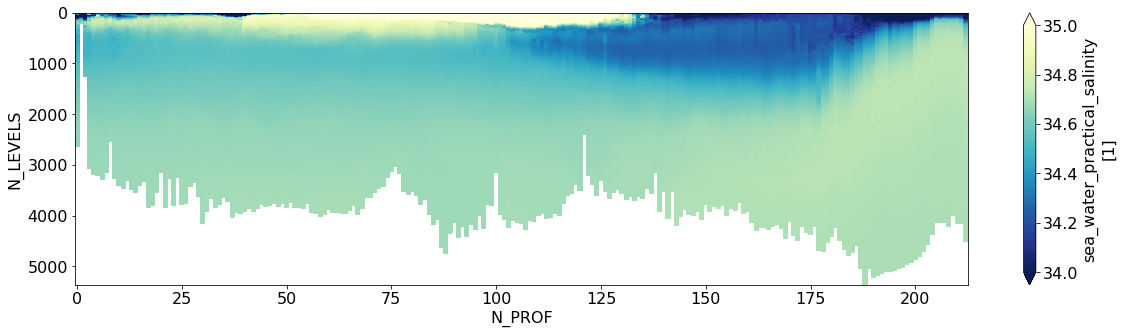

In [3]:
# Simple section plot of Pressure Levels vs along-section Profile
ds_ctd.ctd_salinity.T.plot(figsize=(20,5),yincrease=False,cmap='YlGnBu_r',vmax=35.,vmin=34.)
plt.show()

#### Notice that the Y-dimension of the plot above is in N_LEVELS which is just an index
Alternatively, it would be useful to plot this in terms of a physical quantity such as Pressure or Depth

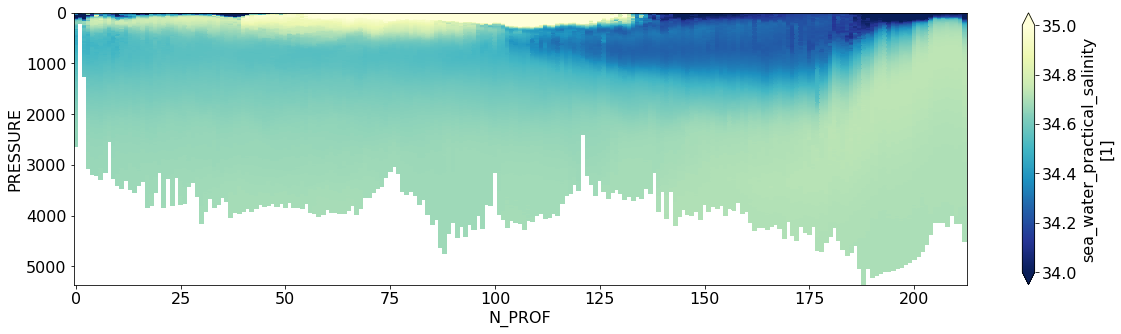

In [4]:
# Linearly Interpolate Salinity onto regular pressure grid and store in a new variable
new_ds = ds_ctd.ctd_salinity.interp_like(ds_ctd.pressure, method='linear')
new_ds = new_ds.rename({'N_LEVELS':'PRESSURE'})  # rename dimension 

# Plot the new dataset variable like before (should be quite similar)
# Simple section plot of Pressure Levels vs along-section Profile
new_ds.T.plot(figsize=(20,5),yincrease=False,cmap='YlGnBu_r',vmax=35.,vmin=34.)
plt.show()


#### Instead of Pressure, we can also try plotting this versus depth.
Here is how-

In [5]:
# Calculate Depth as a function of pressure, latitude
depth = gsw.z_from_p(ds_ctd.pressure,
                     ds_ctd.latitude,)

# Next, we can store depth as a coordinate in our original dataset
ds_ctd = ds_ctd.assign_coords(depth=(('N_PROF', 'N_LEVELS'), depth.data))

# We can add some attributes to it
ds_ctd.depth.attrs = dict(whp_name='depth',whp_unit='meters',standard_name='depth')

ds_ctd.var() # display variables

<xarray.Dataset>
Dimensions:                     (N_LEVELS: 5364, N_PROF: 213)
Coordinates:
    expocode                    (N_PROF) object '33RO20161119' ... '33RO20161...
    station                     (N_PROF) object '1' '2' '3' ... '211' '212'
    cast                        (N_PROF) int32 3 2 1 1 1 1 1 1 ... 2 1 1 1 1 1 1
    sample                      (N_PROF, N_LEVELS) object '3.0' '4.0' ... '' ''
    time                        (N_PROF) datetime64[ns] 2016-11-24T14:17:00 ....
    latitude                    (N_PROF) float64 22.69 22.87 ... -70.0 -68.07
    longitude                   (N_PROF) float64 -110.0 -110.0 ... -100.2 -95.0
    pressure                    (N_PROF, N_LEVELS) float64 3.0 4.0 ... nan nan
    depth                       (N_PROF, N_LEVELS) float64 -2.981 -3.975 ... nan
Dimensions without coordinates: N_LEVELS, N_PROF
Data variables: (12/16)
    section_id                  (N_PROF) object 'P18' 'P18' ... 'P18' 'P18'
    btm_depth                   (N_PROF) float64 2.625e+03 ... 4.435e+03
    pressure_qc                 (N_PROF, N_LEVELS) float32 2.0 2.0 ... nan nan
    ctd_temperature             (N_PROF, N_LEVELS) float64 27.92 27.92 ... nan
    ctd_temperature_qc          (N_PROF, N_LEVELS) float32 3.0 3.0 ... nan nan
    ctd_salinity                (N_PROF, N_LEVELS) float64 34.53 34.53 ... nan
    ...                          ...
    ctd_beamcp                  (N_PROF, N_LEVELS) float64 nan 0.0479 ... nan
    ctd_beamcp_qc               (N_PROF, N_LEVELS) float32 nan 2.0 ... nan nan
    ctd_beta700_raw             (N_PROF, N_LEVELS) float64 0.076 0.076 ... nan
    ctd_number_of_observations  (N_PROF, N_LEVELS) float64 19.0 36.0 ... nan nan
    profile_type                (N_PROF) object 'C' 'C' 'C' 'C' ... 'C' 'C' 'C'
    geometry_container          float64 nan
Attributes:
    Conventions:               CF-1.8 CCHDO-1.0
    cchdo_software_version:    hydro 1.0.2.3
    cchdo_parameters_version:  params 0.1.21
    comments:                  CTD,20200213CCHSIO\n Parameters removed from E...
    featureType:               profile

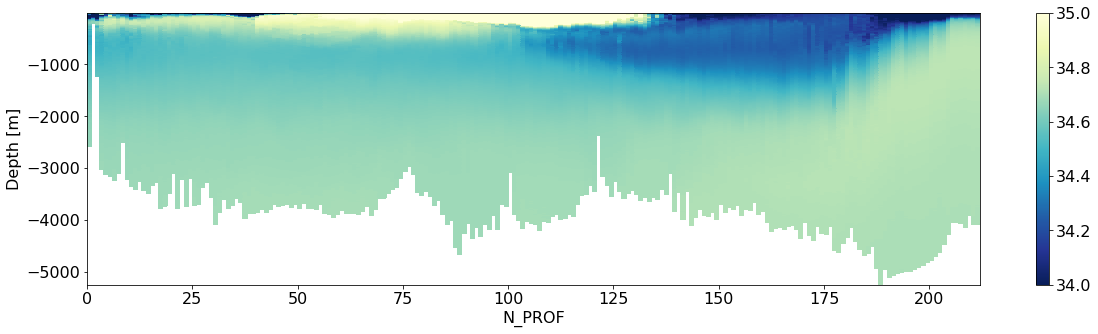

In [6]:
# Plot dataset
plt.figure(figsize=(20,5))
plt.pcolor(ds_ctd.N_PROF,ds_ctd.depth[188,:],ds_ctd.ctd_salinity.T,cmap='YlGnBu_r',
           vmax=35.,vmin=34.)
plt.xlabel('N_PROF')
plt.ylabel('Depth [m]')
plt.colorbar()
plt.show()

#### Next we can take a look at the bathymetry of this section
It can be useful to plot the maximum depth and which CTD station it corresponds to.

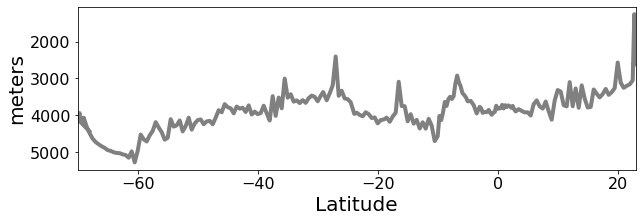

In [7]:
# Plot bottom bathymetry 
ds_ctd['btm_depth'].plot(figsize=(10,3),
                     yincrease=False,
                     x='latitude',
                     color='gray',
                     linewidth=4,
                     xlim=(-70,23),
                     )
plt.ylabel('meters',fontsize=20)
plt.xlabel('Latitude',fontsize=20)
plt.show()

In [8]:
# We can find the CTD station with the maximum bottom depth
STA_MAX_DEPTH = ds_ctd['btm_depth'].argmax()
print(STA_MAX_DEPTH.values)

188


#### Now we can look at some corresponding Bottle and CTD data from this Station

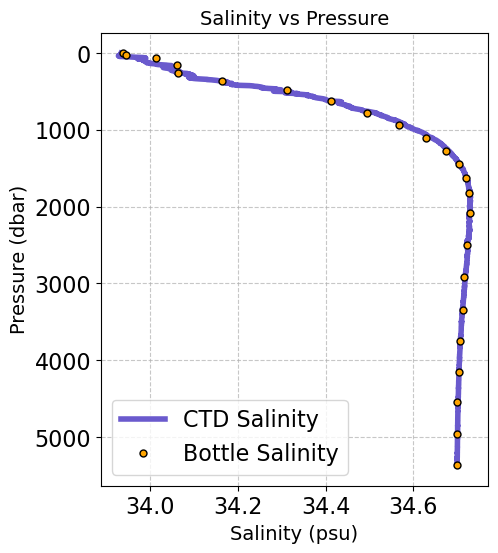

In [9]:
# Create figure
plt.figure(figsize=(5, 6),dpi=100)

# Plot salinity data
plt.plot(ds_ctd.ctd_salinity[STA_MAX_DEPTH, :], ds_ctd.pressure[STA_MAX_DEPTH, :], 
         label='CTD Salinity', color='slateblue', linewidth=4,)

# Plot bottle salinity data
plt.plot(ds_btl.bottle_salinity[STA_MAX_DEPTH, :], ds_btl.pressure[STA_MAX_DEPTH, :], 
         'o', label='Bottle Salinity', color='orange', markersize=5, markeredgecolor='black')

# Invert pressure axis
plt.gca().invert_yaxis()

# Adding titles and labels
plt.title('Salinity vs Pressure', fontsize=14)
plt.xlabel('Salinity (psu)', fontsize=14)
plt.ylabel('Pressure (dbar)', fontsize=14)

plt.legend()
# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

It is also useful sometimes to look at the CTD vs Bottle Mismatch

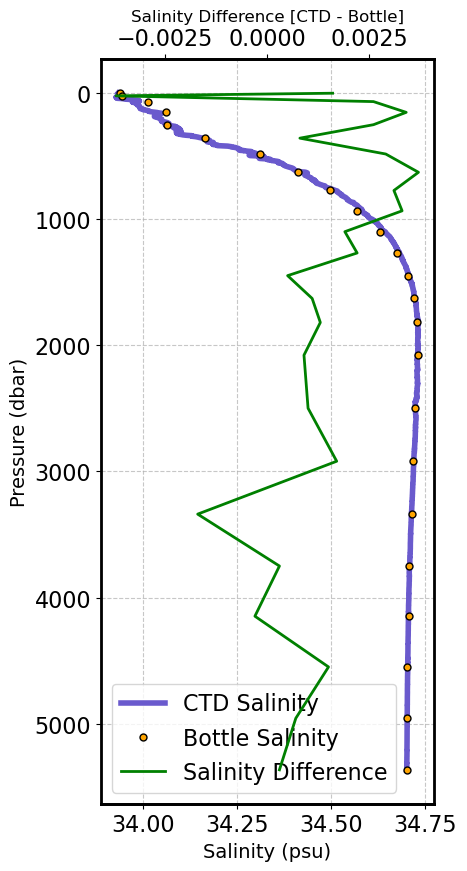

In [10]:
# Create figure
fig, ax1 = plt.subplots(figsize=(5, 9), dpi=100)

# Plot salinity data with labels on ax1 using the specified profile number
line_ctd, = ax1.plot(ds_ctd.ctd_salinity[STA_MAX_DEPTH, :], ds_ctd.pressure[STA_MAX_DEPTH, :], 
                     label='CTD Salinity', color='slateblue', linewidth=4)

# Plot bottle salinity data with labels on ax1 using the specified profile number
line_bottle, = ax1.plot(ds_btl.bottle_salinity[STA_MAX_DEPTH, :], ds_btl.pressure[STA_MAX_DEPTH, :], 
                        'o', label='Bottle Salinity', color='orange', markersize=5, markeredgecolor='black')

# Invert pressure axis
ax1.invert_yaxis()

# Set labels for the axes on ax1
ax1.set_xlabel('Salinity (psu)', fontsize=14)
ax1.set_ylabel('Pressure (dbar)', fontsize=14)

# Add grid
ax1.grid(True, linestyle='--', alpha=0.7)

# Create a second x-axis on the top using ax2
ax2 = ax1.twiny()

# Calculate the difference between CTD and Bottle salinity using the specified profile number
salinity_difference = ds_btl.ctd_salinity[STA_MAX_DEPTH, :] - ds_btl.bottle_salinity[STA_MAX_DEPTH, :]

# Plot the difference on the second x-axis
line_difference, = ax2.plot(salinity_difference, ds_btl.pressure[STA_MAX_DEPTH, :], 
                             color='green', linewidth=2, label='Salinity Difference')

# Set label for the second x-axis
ax2.set_xlabel('Salinity Difference [CTD - Bottle]', fontsize=12)

# Combine legends from both axes
lines = [line_ctd, line_bottle, line_difference]  # List of handles for the legend
labels = [line.get_label() for line in lines]  # Get the labels from the handles
ax1.legend(lines, labels, loc='lower left')  # Create a single legend

# Make axis splines bold
ax1.spines['top'].set_linewidth(2)   # Top spine for ax1
ax1.spines['bottom'].set_linewidth(2) # Bottom spine for ax1
ax1.spines['left'].set_linewidth(2)   # Left spine for ax1
ax1.spines['right'].set_linewidth(2)  # Right spine for ax1
ax2.spines['top'].set_linewidth(2)     # Top spine for ax2
ax2.spines['bottom'].set_linewidth(2)  # Bottom spine for ax2

# Display the plot
plt.tight_layout()
plt.show()
